# 0. 라이브러리

In [1]:
# !pip install -r requirements.txt
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=565b01ddf4e1d553a94b1c0c3c395ccdb3b31509acbbe0bfe8cdae3eef5a1860
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


# 1. Load Data

In [2]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_self_attention import SeqSelfAttention
from sklearn.preprocessing import MinMaxScaler
from keras.utils.vis_utils import plot_model

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pickle
import random

In [3]:
# 혹시모르니 아래 코드 세개 다 쓰기
seed_num = 42
tf.random.set_seed(seed_num)
np.random.seed(seed_num)
random.seed(seed_num)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# data load
# data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/5c_VaderPolar_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/5c_VaderPolar_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/5c_VaderPolar_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)


In [ ]:
overall = train_set.shape[0] + valid_set.shape[0] + test_set.shape[0]
print('train:validation:test = %.4f:%.4f:%.4f'%((train_set.shape[0] / overall), (valid_set.shape[0] / overall), (test_set.shape[0] / overall)))

train:validation:test = 0.7000:0.1000:0.2000


In [6]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

,userID,movieID,rating,compound,pos,neu,neg,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
1268783,196894,17092,1.00,0.9118,0.795,0.205,0.000,0.00,16.67,0.00,0.00,33.33,0.00,0.00,0.00,0.00,33.33
2085294,144722,36136,1.00,0.8020,0.423,0.495,0.082,8.33,0.00,8.33,0.00,0.00,16.67,0.00,8.33,16.67,8.33
1601782,187298,26274,1.00,0.9657,0.263,0.697,0.039,1.11,10.00,0.00,6.67,2.22,0.00,2.22,6.67,1.11,10.00
286943,140132,31748,1.00,0.9667,0.621,0.379,0.000,0.00,0.00,0.00,0.00,17.65,0.00,0.00,5.88,0.00,17.65
1072946,101551,10355,0.75,0.8957,0.496,0.504,0.000,6.25,31.25,0.00,6.25,31.25,12.50,25.00,31.25,0.00,31.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612962,42980,58606,1.00,0.9958,0.512,0.488,0.000,0.00,8.86,0.00,0.00,12.66,0.00,5.06,7.59,0.00,20.25
1855528,23396,32231,1.00,0.9628,0.206,0.704,0.090,2.42,6.45,2.42,4.03,5.65,1.61,1.61,7.26,8.06,11.29
2025236,134838,35643,1.00,0.9903,0.521,0.443,0.036,1.85,7.41,1.85,3.70,7.41,0.00,1.85,5.56,1.85,11.11
1028586,46156,9128,1.00,0.8166,0.517,0.483,0.000,0.00,22.22,0.00,11.11,22.22,0.00,0.00,22.22,0.00,22.22


# 8개 감정 0을 제외한 값 개수 보기 - train set 기준

In [10]:
values = train_set[train_set != 0].count()

# Display the counts
print(values)

userID          2265743
movieID         2265744
rating          2137573
compound        2139700
pos             2079697
neu             2107342
neg             1037261
anger            819134
anticipation    1536255
disgust          724449
fear            1075247
joy             1636276
sadness          851424
surprise        1179163
trust           1565589
negative        1109757
positive        1844081
dtype: int64


# 3.Model

In [ ]:
def conv_block(n_layers, latent_dims, names):
    ModuleList, DropoutList = [], []
    for i, _ in enumerate(range(n_layers)):
        ModuleList.append(Dense(latent_dims, activation='relu', name=f'{names}{i+1}'))
        latent_dims //= 2
    return ModuleList

In [ ]:
def ModelBuild(user_num, item_num, id_dims, total_layer_dims, total_n_layer):
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)
    # user
    user_input = Input(shape=(1,), dtype='int32', name='UserInput')
    user_embedding = Embedding(user_num, id_dims, input_length=user_input.shape[1], name='UserIDEmb')(user_input)
    user_embedding = Flatten(name='UserFlatten')(user_embedding)

    # item
    item_input = Input(shape=(1,), dtype='int32', name='ItemInput')
    item_embedding = Embedding(item_num, id_dims, input_length=item_input.shape[1], name='ItemIDEmb')(item_input)
    item_embedding = Flatten(name='ItemFlatten')(item_embedding)


    # GMF
    # GMF = Multiply()([user_embedding, item_embedding])

    # MLP
    MLP_U_I = Concatenate(name='UserItemLayer')([user_embedding, item_embedding])

    for layer in conv_block(total_n_layer, total_layer_dims, 'UserItemMLP'):
        MLP_U_I = layer(MLP_U_I)


    # Sentiment
    # pos_input = Input(shape=(1,), dtype='int32', name='PositiveInput')
    # pos_dense = Dense(units=1, activation='relu', name='Dense_Positive')(pos_input)

    # neg_input = Input(shape=(1,), dtype='int32', name='NegativeInput')
    # neg_dense = Dense(units=1, activation='relu', name='Dense_Negative')(neg_input)

    # anger_input = Input(shape=(1,), dtype='int32', name='AnticipationInput')
    # anger_dense = Dense(units=1, activation='relu', name='Dense_Anticipation')(anger_input)

    # anticipation_input = Input(shape=(1,), dtype='int32', name='AnticipationInput')
    # anticipation_dense = Dense(units=1, activation='relu', name='Dense_Anticipation')(anticipation_input)


    # fear_input = Input(shape=(1,), dtype='int32', name='FearInput')
    # fear_dense = Dense(units=1, activation='relu', name='Dense_Fear')(fear_input)

    disgust_input = Input(shape=(1,), dtype='int32', name='DisgustInput')
    disgust_dense = Dense(units=1, activation='relu', name='Dense_Disgust')(disgust_input)

    joy_input = Input(shape=(1,), dtype='int32', name='JoyInput')
    joy_dense = Dense(units=1, activation='relu', name='Dense_Joy')(joy_input)

    sadness_input = Input(shape=(1,), dtype='int32', name='SadnessInput')
    sadness_dense = Dense(units=1, activation='relu', name='Dense_Sadness')(sadness_input)

    surprise_input = Input(shape=(1,), dtype='int32', name='SurpriseInput')
    surprise_dense = Dense(units=1, activation='relu', name='Dense_Surprise')(surprise_input)

    trust_input = Input(shape=(1,), dtype='int32', name='TrustInput')
    trust_dense = Dense(units=1, activation='relu', name='Dense_Trust')(trust_input)

    # Sentiment = Concatenate(name='SentimentLayer')([anger_dense, anticipation_dense, disgust_dense, fear_dense, joy_dense, sadness_dense, surprise_dense, trust_dense])
    # Sentiment concatenation
    MLP_U_I_S = Concatenate(name='UserItemSentimentLayer')([MLP_U_I, joy_dense, sadness_dense, trust_dense, disgust_dense, surprise_dense])

    # Final concatenation
    # MLP_U_I_S = Concatenate(name='FinalLayer')([MLP_U_I, Sentiment])

    for layer in conv_block(total_n_layer, (total_layer_dims//(2**(total_n_layer-1))+8)//2, 'UserItemSentimentMLP'):
        MLP_U_I_S = layer(MLP_U_I_S)

    outputs = Dense(1, activation='sigmoid', name='outputs')(MLP_U_I_S)
    model = Model(inputs=[user_input, item_input, joy_input, sadness_input, trust_input, disgust_input, surprise_input], outputs=outputs)
    return model

In [ ]:
def model_run_param(id_dims, total_layer_dims,total_n_layer,lr):

    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)

    model = ModelBuild(user_num = user_num, item_num = item_num, id_dims = id_dims, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)

    adam = Adam(learning_rate=lr)
    model.compile(optimizer=adam, loss='binary_crossentropy')
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 3, restore_best_weights = True)
    # model.summary()

    history = model.fit([train_set['userID'], train_set['movieID'], train_set['joy'] , train_set['sadness'] , train_set['trust'], train_set['disgust'] , train_set['surprise'] ],
                train_set['rating'],
                batch_size = 1024,
                epochs = 100,
                callbacks=[es],
                validation_data = ([valid_set['userID'], valid_set['movieID'],valid_set['joy'] ,valid_set['sadness'] ,valid_set['trust'], valid_set['disgust'], valid_set['surprise']],
                valid_set['rating']))

    prediction = model.predict([test_set['userID'], test_set['movieID'], test_set['joy'], test_set['sadness'], test_set['trust'], test_set['disgust'], test_set['surprise']])

    # normalize 안해도 되겠단 생각이..
    # prediction = 4 * norm(prediction) + 1
    prediction = 4 * prediction + 1

    MAE_temp = mean_absolute_error(test_set['rating'], prediction)
    RMSE_temp = mean_squared_error(test_set['rating'], prediction, squared = False)
    embedding_size = id_dims
    layer_dim = total_layer_dims
    lr = lr
    print(f'embedding:{embedding_size}, layer_dim:{layer_dim},lr:{lr}')
    print(f'MAE: {MAE_temp:.3f}')
    print(f'RMSE: {RMSE_temp:.3f}')

    return MAE_temp, RMSE_temp, embedding_size, layer_dim, lr

In [ ]:
user_num = 281335
item_num = 59044

id_dims = 128# each 32 dims
total_layer_dims = 32 # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16

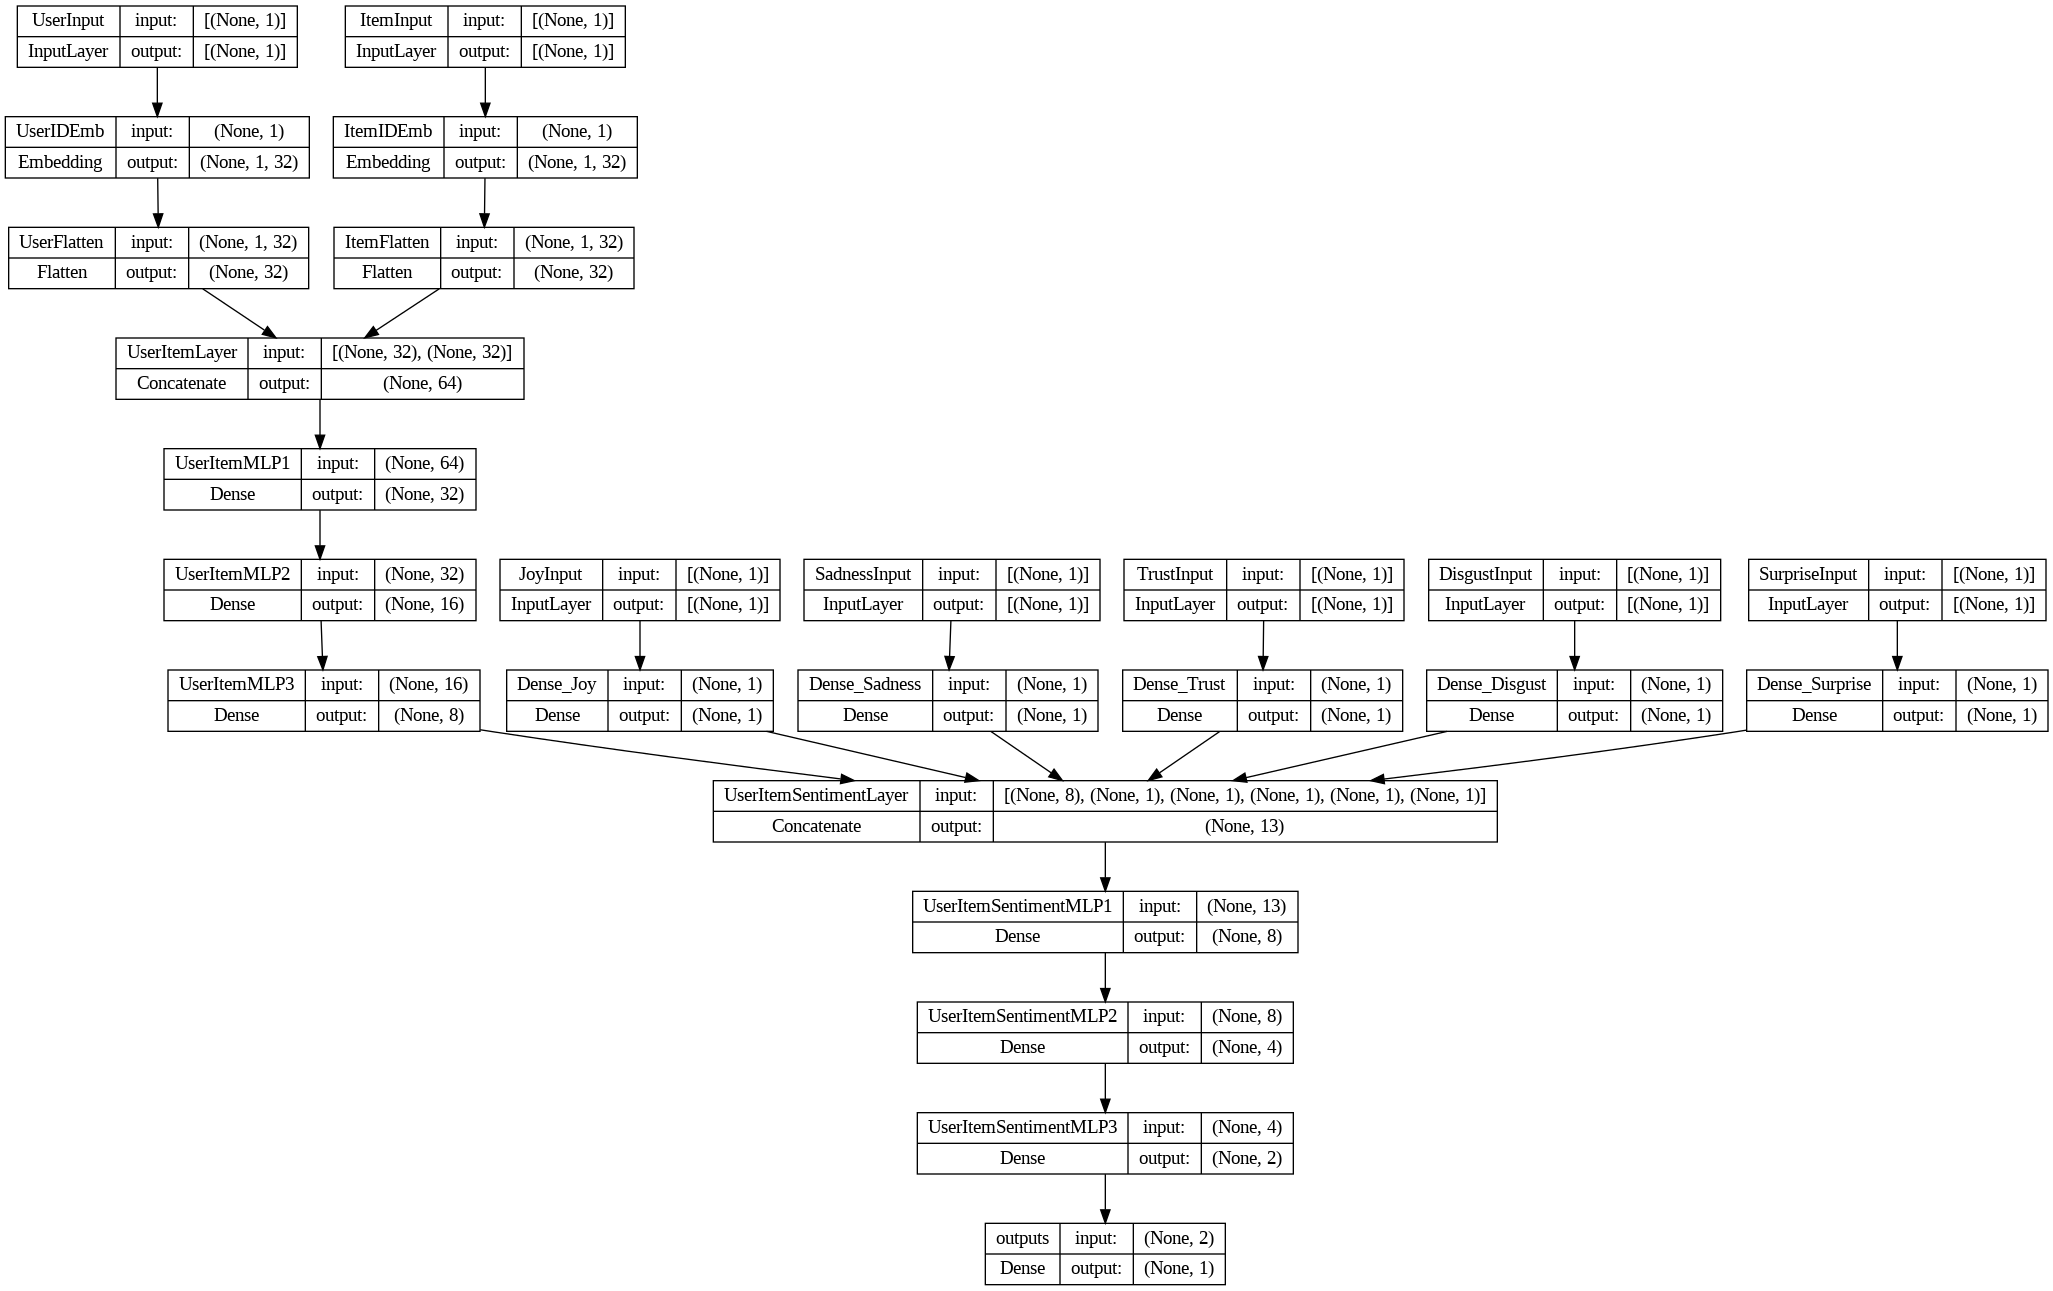

In [ ]:
model = ModelBuild(user_num = 281335, item_num = 59044, id_dims = 32, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)
plot_model(model, show_shapes=True, show_layer_names=True)

# n-core 실험
### sparsity 정리

- -----
- 2core userID num :  297514
- 2core movieID num :  60085
- 2core rating num :  3300653
- sparsity : 0.00018464025725
- -----
- 5core userID num :  281335
- 5core movieID num :  59044
- 5core rating num :   3215686
- sparsity : 0.000193586067903
- -----
- 10core userID num :  79067
- 10core movieID num :  29829
- 10core rating num :  1765142
- sparsity : 0.0007484205326408776
- -----
- 15core userID num :  33532
- 15core movieID num :  17250
- 15core rating num :  1098649
- sparsity : 0.0018993736461126469
- -----
- 20core userID num :  16007
- 20core movieID num :  9774
- 20core rating num :  685408
- sparsity : 0.004380935806310133

### 5-core 실험
- 5core userID num :  281335
- 5core movieID num :  59044
- 5core rating num :   3215686
- sparsity : 0.000193586067903

In [ ]:
'''
- 5core userID num :  281335
- 5core movieID num :  59044
- 5core rating num :   3215686
- sparsity : 0.000193586067903

- 5core userID num :  281887
- 5core movieID num :  59252
- 5core rating num :  3236784
'''

# 다시 시도...
user_num = 281887
item_num = 59252

id_dims = [128,64,32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
2213/2213 [==============================] - 44s 15ms/step - loss: 0.4208 - val_loss: 0.3952
Epoch 2/100
2213/2213 [==============================] - 19s 9ms/step - loss: 0.3628 - val_loss: 0.3966
Epoch 3/100
2213/2213 [==============================] - 17s 8ms/step - loss: 0.3299 - val_loss: 0.4125
Epoch 4/100
2213/2213 [==============================] - 17s 8ms/step - loss: 0.2970 - val_loss: 0.4410
Epoch 4: early stopping
20230/20230 [==============================] - 41s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.637
RMSE: 0.922
Epoch 1/100
2213/2213 [==============================] - 34s 13ms/step - loss: 0.4142 - val_loss: 0.3960
Epoch 2/100
2213/2213 [==============================] - 19s 8ms/step - loss: 0.3616 - val_loss: 0.3986
Epoch 3/100
2213/2213 [==============================] - 17s 8ms/step - loss: 0.3308 - val_loss: 0.4188
Epoch 4/100
2213/2213 [==============================] - 18s 8ms/step - loss: 0.3031 - val_loss: 0.4435
Epoch 4: early stoppi

KeyboardInterrupt: ignored

In [ ]:
core5_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core5_df

In [ ]:
core5_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000-extra3.5emotions-5corePolar.csv",index=False)


### 10-core 실험
- 10core userID num :  79067
- 10core movieID num :  29829
- 10core rating num :  1765142
- sparsity : 0.0007484205326408776

In [ ]:
# 10-core data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/10c_VaderPolar_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/10c_VaderPolar_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/10c_VaderPolar_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

In [ ]:
'''
- 10core userID num :  79067
- 10core movieID num :  29829
- 10core rating num :  1765142
- sparsity : 0.0007484205326408776

- 10core userID num :  79542
- 10core movieID num :  30084
- 10core rating num :  1785734
'''

# 다시 시도...
user_num = 79542
item_num = 30084

id_dims = [128,64,32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

In [ ]:
core10_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core10_df

In [ ]:
core10_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000-extra3.5emotions-10corePolar.csv",index=False)



### 15-core 실험
- 15core userID num :  33532
- 15core movieID num :  17250
- 15core rating num :  1098649
- sparsity : 0.0018993736461126469

In [ ]:
# 15-core data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/15c_VaderPolar_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/15c_VaderPolar_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/15c_VaderPolar_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

In [ ]:
'''
- 15core userID num :  33532
- 15core movieID num :  17250
- 15core rating num :  1098649
- sparsity : 0.0018993736461126469

- 15core userID num :  33821
- 15core movieID num :  17410
- 15core rating num :  1115902
'''

# 다시 시도...
user_num = 33821
item_num = 17410

id_dims = [128,64, 32]
total_layer_dims =  [128,64, 32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

In [ ]:
core15_df= pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core15_df

In [ ]:
core15_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000-extra3.5emotions-15corePolar.csv",index=False)




### 20-core 실험
- 20core userID num :  16007
- 20core movieID num :  9774
- 20core rating num :  685408
- sparsity : 0.004380935806310133

In [ ]:
# 20-core data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/20c_VaderPolar_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/20c_VaderPolar_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/20c_VaderPolar_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

In [ ]:
'''
- 20core userID num :  16007
- 20core movieID num :  9774
- 20core rating num :  685408
- sparsity : 0.004380935806310133

- 20core userID num :  16221
- 20core movieID num :  9919
- 20core rating num :  701036
'''

# 다시 시도...
user_num = 16221
item_num = 9919

id_dims = [128,64,32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

In [ ]:
core20_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core20_df

In [ ]:
core20_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000-extra3.5emotions-20corePolar.csv",index=False)


### 2-core 실험
- 2core userID num :  297514
- 2core movieID num :  60085
- 2core rating num :  3300653
- sparsity : 0.00018464025725

In [ ]:
# 20-core data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/2c_VaderPolar_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/2c_VaderPolar_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/2c_VaderPolar_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

In [ ]:
'''
- 2core userID num :  297514
- 2core movieID num :  60085
- 2core rating num :  3300653
- sparsity : 0.00018464025725

'''
# 다시 시도...
user_num = 297514
item_num = 60085

id_dims = [128, 64, 32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
2257/2257 [==============================] - 42s 16ms/step - loss: 0.4200 - val_loss: 0.3945
Epoch 2/100
2257/2257 [==============================] - 20s 9ms/step - loss: 0.3614 - val_loss: 0.3964
Epoch 3/100
2257/2257 [==============================] - 21s 9ms/step - loss: 0.3273 - val_loss: 0.4113
Epoch 4/100
2257/2257 [==============================] - 20s 9ms/step - loss: 0.2941 - val_loss: 0.4450
Epoch 4: early stopping
20630/20630 [==============================] - 42s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.651
RMSE: 0.924
Epoch 1/100
2257/2257 [==============================] - 37s 14ms/step - loss: 0.4136 - val_loss: 0.3949
Epoch 2/100
2257/2257 [==============================] - 20s 9ms/step - loss: 0.3598 - val_loss: 0.3976
Epoch 3/100
2257/2257 [==============================] - 20s 9ms/step - loss: 0.3275 - val_loss: 0.4167
Epoch 4/100
2257/2257 [==============================] - 20s 9ms/step - loss: 0.2995 - val_loss: 0.4367
Epoch 4: early stoppi

In [ ]:
core2_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core2_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.650574,0.923815
1,128,128,0.005,0.655110,0.925093
2,128,64,0.001,0.651011,0.925195
3,128,64,0.005,0.632163,0.928316
4,128,32,0.001,0.648598,0.931602
5,128,32,0.005,0.927411,1.167088
6,64,128,0.001,0.651325,0.925590
7,64,128,0.005,0.655773,0.924836
8,64,64,0.001,0.652450,0.926318
9,64,64,0.005,0.660840,0.930928


In [ ]:
core2_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000-extra3.5emotions-2corePolar.csv",index=False)


# 추가 - 5emotions & compound

In [ ]:
def ModelBuild(user_num, item_num, id_dims, total_layer_dims, total_n_layer):
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)
    # user
    user_input = Input(shape=(1,), dtype='int32', name='UserInput')
    user_embedding = Embedding(user_num, id_dims, input_length=user_input.shape[1], name='UserIDEmb')(user_input)
    user_embedding = Flatten(name='UserFlatten')(user_embedding)

    # item
    item_input = Input(shape=(1,), dtype='int32', name='ItemInput')
    item_embedding = Embedding(item_num, id_dims, input_length=item_input.shape[1], name='ItemIDEmb')(item_input)
    item_embedding = Flatten(name='ItemFlatten')(item_embedding)


    # GMF
    # GMF = Multiply()([user_embedding, item_embedding])

    # MLP
    MLP_U_I = Concatenate(name='UserItemLayer')([user_embedding, item_embedding])

    for layer in conv_block(total_n_layer, total_layer_dims, 'UserItemMLP'):
        MLP_U_I = layer(MLP_U_I)


    # Sentiment
    # pos_input = Input(shape=(1,), dtype='int32', name='PositiveInput')
    # pos_dense = Dense(units=1, activation='relu', name='Dense_Positive')(pos_input)

    # neg_input = Input(shape=(1,), dtype='int32', name='NegativeInput')
    # neg_dense = Dense(units=1, activation='relu', name='Dense_Negative')(neg_input)

    # anger_input = Input(shape=(1,), dtype='int32', name='AnticipationInput')
    # anger_dense = Dense(units=1, activation='relu', name='Dense_Anticipation')(anger_input)

    # anticipation_input = Input(shape=(1,), dtype='int32', name='AnticipationInput')
    # anticipation_dense = Dense(units=1, activation='relu', name='Dense_Anticipation')(anticipation_input)


    # fear_input = Input(shape=(1,), dtype='int32', name='FearInput')
    # fear_dense = Dense(units=1, activation='relu', name='Dense_Fear')(fear_input)

    disgust_input = Input(shape=(1,), dtype='int32', name='DisgustInput')
    disgust_dense = Dense(units=1, activation='relu', name='Dense_Disgust')(disgust_input)

    joy_input = Input(shape=(1,), dtype='int32', name='JoyInput')
    joy_dense = Dense(units=1, activation='relu', name='Dense_Joy')(joy_input)

    sadness_input = Input(shape=(1,), dtype='int32', name='SadnessInput')
    sadness_dense = Dense(units=1, activation='relu', name='Dense_Sadness')(sadness_input)

    surprise_input = Input(shape=(1,), dtype='int32', name='SurpriseInput')
    surprise_dense = Dense(units=1, activation='relu', name='Dense_Surprise')(surprise_input)

    trust_input = Input(shape=(1,), dtype='int32', name='TrustInput')
    trust_dense = Dense(units=1, activation='relu', name='Dense_Trust')(trust_input)

    compound_input = Input(shape=(1,), dtype='int32', name='CompoundInput')
    compound_dense = Dense(units=1, activation='relu', name='Dense_Compound')(trust_input)

    # Sentiment = Concatenate(name='SentimentLayer')([anger_dense, anticipation_dense, disgust_dense, fear_dense, joy_dense, sadness_dense, surprise_dense, trust_dense])
    # Sentiment concatenation
    MLP_U_I_S = Concatenate(name='UserItemSentimentLayer')([MLP_U_I, joy_dense, sadness_dense, trust_dense, disgust_dense, surprise_dense, compound_dense])

    # Final concatenation
    # MLP_U_I_S = Concatenate(name='FinalLayer')([MLP_U_I, Sentiment])

    for layer in conv_block(total_n_layer, (total_layer_dims//(2**(total_n_layer-1))+8)//2, 'UserItemSentimentMLP'):
        MLP_U_I_S = layer(MLP_U_I_S)

    outputs = Dense(1, activation='sigmoid', name='outputs')(MLP_U_I_S)
    model = Model(inputs=[user_input, item_input, joy_input, sadness_input, trust_input, disgust_input, surprise_input, compound_input], outputs=outputs)
    return model

In [ ]:
def model_run_param(id_dims, total_layer_dims,total_n_layer,lr):

    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)

    model = ModelBuild(user_num = user_num, item_num = item_num, id_dims = id_dims, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)

    adam = Adam(learning_rate=lr)
    model.compile(optimizer=adam, loss='binary_crossentropy')
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 3, restore_best_weights = True)
    # model.summary()

    history = model.fit([train_set['userID'], train_set['movieID'], train_set['joy'] , train_set['sadness'] , train_set['trust'], train_set['disgust'] , train_set['surprise'], train_set['compound']  ],
                train_set['rating'],
                batch_size = 1024,
                epochs = 100,
                callbacks=[es],
                validation_data = ([valid_set['userID'], valid_set['movieID'],valid_set['joy'] ,valid_set['sadness'] ,valid_set['trust'], valid_set['disgust'], valid_set['surprise'], valid_set['compound']],
                valid_set['rating']))

    prediction = model.predict([test_set['userID'], test_set['movieID'], test_set['joy'], test_set['sadness'], test_set['trust'], test_set['disgust'], test_set['surprise'], test_set['compound']])

    # normalize 안해도 되겠단 생각이..
    # prediction = 4 * norm(prediction) + 1
    prediction = 4 * prediction + 1

    MAE_temp = mean_absolute_error(test_set['rating'], prediction)
    RMSE_temp = mean_squared_error(test_set['rating'], prediction, squared = False)
    embedding_size = id_dims
    layer_dim = total_layer_dims
    lr = lr
    print(f'embedding:{embedding_size}, layer_dim:{layer_dim},lr:{lr}')
    print(f'MAE: {MAE_temp:.3f}')
    print(f'RMSE: {RMSE_temp:.3f}')

    return MAE_temp, RMSE_temp, embedding_size, layer_dim, lr

In [ ]:
# data load
with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)


In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

,userID,movieID,rating,compound,senti_score,NeMFRating,SBMFRating,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
1633870,143756,31800,1.00,0.5719,3,3,4,0.00,0.00,0.00,0.00,16.67,0.00,0.00,33.33,0.00,16.67
3115182,272600,13746,1.00,0.0000,2,3,3,0.00,11.11,0.00,11.11,0.00,0.00,0.00,11.11,0.00,0.00
2383131,208589,23849,0.50,-0.2023,1,2,3,10.53,5.26,5.26,5.26,0.00,5.26,5.26,5.26,10.53,10.53
2079042,182422,14736,0.75,0.9666,3,3,5,5.04,4.20,9.24,8.40,6.72,7.56,5.04,4.20,14.29,13.45
651398,56973,53386,1.00,0.9260,3,3,5,0.00,27.27,0.00,4.55,18.18,0.00,13.64,40.91,0.00,27.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158490,13844,27705,1.00,0.7351,3,3,4,0.00,0.00,0.00,0.00,8.00,0.00,0.00,20.00,0.00,12.00
1734117,152410,28106,0.75,0.8750,3,3,5,0.00,3.77,0.00,3.77,3.77,0.00,3.77,11.32,3.77,5.66
1564450,137584,43164,1.00,0.6249,3,3,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,33.33
212205,18521,42215,1.00,0.4588,3,3,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# 다시 시도...
user_num = 297514
item_num = 60085

id_dims = [128, 64, 32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
2199/2199 [==============================] - 38s 15ms/step - loss: 0.5646 - val_loss: 0.4964
Epoch 2/100
2199/2199 [==============================] - 20s 9ms/step - loss: 0.4942 - val_loss: 0.4942
Epoch 3/100
2199/2199 [==============================] - 20s 9ms/step - loss: 0.4939 - val_loss: 0.4942
Epoch 4/100
2199/2199 [==============================] - 20s 9ms/step - loss: 0.4939 - val_loss: 0.4942
Epoch 5/100
2199/2199 [==============================] - 19s 9ms/step - loss: 0.4939 - val_loss: 0.4942
Epoch 6/100
2199/2199 [==============================] - 20s 9ms/step - loss: 0.4939 - val_loss: 0.4942
Epoch 7/100
2199/2199 [==============================] - 20s 9ms/step - loss: 0.4939 - val_loss: 0.4942
Epoch 7: early stopping
20099/20099 [==============================] - 41s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.928
RMSE: 1.167
Epoch 1/100
2199/2199 [==============================] - 36s 14ms/step - loss: 0.4512 - val_loss: 0.4058
Epoch 2/100
2199/2199

In [ ]:
Vader_5emo_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
Vader_5emo_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.927857,1.167441
1,128,128,0.005,0.637106,0.922677
2,128,64,0.001,0.626171,0.924493
3,128,64,0.005,0.628362,0.922995
4,128,32,0.001,0.664798,0.939441
5,128,32,0.005,0.651776,0.931758
6,64,128,0.001,0.927848,1.167444
7,64,128,0.005,0.643115,0.923323
8,64,64,0.001,0.622969,0.923338
9,64,64,0.005,0.659619,0.927171


In [ ]:
Vader_5emo_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000-extra3.5emotions+Vader-5core.csv",index=False)


# 추가2 - 5emotions & polarity

In [ ]:
def ModelBuild(user_num, item_num, id_dims, total_layer_dims, total_n_layer):
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)
    # user
    user_input = Input(shape=(1,), dtype='int32', name='UserInput')
    user_embedding = Embedding(user_num, id_dims, input_length=user_input.shape[1], name='UserIDEmb')(user_input)
    user_embedding = Flatten(name='UserFlatten')(user_embedding)

    # item
    item_input = Input(shape=(1,), dtype='int32', name='ItemInput')
    item_embedding = Embedding(item_num, id_dims, input_length=item_input.shape[1], name='ItemIDEmb')(item_input)
    item_embedding = Flatten(name='ItemFlatten')(item_embedding)


    # GMF
    # GMF = Multiply()([user_embedding, item_embedding])

    # MLP
    MLP_U_I = Concatenate(name='UserItemLayer')([user_embedding, item_embedding])

    for layer in conv_block(total_n_layer, total_layer_dims, 'UserItemMLP'):
        MLP_U_I = layer(MLP_U_I)


    # Sentiment
    pos_input = Input(shape=(1,), dtype='int32', name='PositiveInput')
    pos_dense = Dense(units=1, activation='relu', name='Dense_Positive')(pos_input)

    neg_input = Input(shape=(1,), dtype='int32', name='NegativeInput')
    neg_dense = Dense(units=1, activation='relu', name='Dense_Negative')(neg_input)

    # anger_input = Input(shape=(1,), dtype='int32', name='AnticipationInput')
    # anger_dense = Dense(units=1, activation='relu', name='Dense_Anticipation')(anger_input)

    # anticipation_input = Input(shape=(1,), dtype='int32', name='AnticipationInput')
    # anticipation_dense = Dense(units=1, activation='relu', name='Dense_Anticipation')(anticipation_input)


    # fear_input = Input(shape=(1,), dtype='int32', name='FearInput')
    # fear_dense = Dense(units=1, activation='relu', name='Dense_Fear')(fear_input)

    disgust_input = Input(shape=(1,), dtype='int32', name='DisgustInput')
    disgust_dense = Dense(units=1, activation='relu', name='Dense_Disgust')(disgust_input)

    joy_input = Input(shape=(1,), dtype='int32', name='JoyInput')
    joy_dense = Dense(units=1, activation='relu', name='Dense_Joy')(joy_input)

    sadness_input = Input(shape=(1,), dtype='int32', name='SadnessInput')
    sadness_dense = Dense(units=1, activation='relu', name='Dense_Sadness')(sadness_input)

    surprise_input = Input(shape=(1,), dtype='int32', name='SurpriseInput')
    surprise_dense = Dense(units=1, activation='relu', name='Dense_Surprise')(surprise_input)

    trust_input = Input(shape=(1,), dtype='int32', name='TrustInput')
    trust_dense = Dense(units=1, activation='relu', name='Dense_Trust')(trust_input)

    # compound_input = Input(shape=(1,), dtype='int32', name='CompoundInput')
    # compound_dense = Dense(units=1, activation='relu', name='Dense_Compound')(trust_input)

    # Sentiment = Concatenate(name='SentimentLayer')([anger_dense, anticipation_dense, disgust_dense, fear_dense, joy_dense, sadness_dense, surprise_dense, trust_dense])
    # Sentiment concatenation
    MLP_U_I_S = Concatenate(name='UserItemSentimentLayer')([MLP_U_I, joy_dense, sadness_dense, trust_dense, disgust_dense, surprise_dense, pos_dense,neg_dense ])

    # Final concatenation
    # MLP_U_I_S = Concatenate(name='FinalLayer')([MLP_U_I, Sentiment])

    for layer in conv_block(total_n_layer, (total_layer_dims//(2**(total_n_layer-1))+8)//2, 'UserItemSentimentMLP'):
        MLP_U_I_S = layer(MLP_U_I_S)

    outputs = Dense(1, activation='sigmoid', name='outputs')(MLP_U_I_S)
    model = Model(inputs=[user_input, item_input, joy_input, sadness_input, trust_input, disgust_input, surprise_input, pos_input,neg_input], outputs=outputs)
    return model

In [ ]:
def model_run_param(id_dims, total_layer_dims,total_n_layer,lr):

    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)

    model = ModelBuild(user_num = user_num, item_num = item_num, id_dims = id_dims, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)

    adam = Adam(learning_rate=lr)
    model.compile(optimizer=adam, loss='binary_crossentropy')
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 3, restore_best_weights = True)
    # model.summary()

    history = model.fit([train_set['userID'], train_set['movieID'], train_set['joy'] , train_set['sadness'] , train_set['trust'], train_set['disgust'] , train_set['surprise'], train_set['positive'], train_set['negative'] ],
                train_set['rating'],
                batch_size = 1024,
                epochs = 100,
                callbacks=[es],
                validation_data = ([valid_set['userID'], valid_set['movieID'],valid_set['joy'] ,valid_set['sadness'] ,valid_set['trust'], valid_set['disgust'], valid_set['surprise'], valid_set['positive'], valid_set['negative']],
                valid_set['rating']))

    prediction = model.predict([test_set['userID'], test_set['movieID'], test_set['joy'], test_set['sadness'], test_set['trust'], test_set['disgust'], test_set['surprise'], test_set['positive'], test_set['negative']])

    # normalize 안해도 되겠단 생각이..
    # prediction = 4 * norm(prediction) + 1
    prediction = 4 * prediction + 1

    MAE_temp = mean_absolute_error(test_set['rating'], prediction)
    RMSE_temp = mean_squared_error(test_set['rating'], prediction, squared = False)
    embedding_size = id_dims
    layer_dim = total_layer_dims
    lr = lr
    print(f'embedding:{embedding_size}, layer_dim:{layer_dim},lr:{lr}')
    print(f'MAE: {MAE_temp:.3f}')
    print(f'RMSE: {RMSE_temp:.3f}')

    return MAE_temp, RMSE_temp, embedding_size, layer_dim, lr

In [ ]:
# data load
# with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_train.pkl', 'rb') as f:
#     train_set = pickle.load(f)
# with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_test.pkl', 'rb') as f:
#     test_set = pickle.load(f)
# with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_validation.pkl', 'rb') as f:
#     valid_set = pickle.load(f)

with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/5c_VaderPolar_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/5c_VaderPolar_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/5c_VaderPolar_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

,userID,movieID,rating,compound,senti_score,NeMFRating,SBMFRating,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
1633870,143756,31800,1.00,0.5719,3,3,4,0.00,0.00,0.00,0.00,16.67,0.00,0.00,33.33,0.00,16.67
3115182,272600,13746,1.00,0.0000,2,3,3,0.00,11.11,0.00,11.11,0.00,0.00,0.00,11.11,0.00,0.00
2383131,208589,23849,0.50,-0.2023,1,2,3,10.53,5.26,5.26,5.26,0.00,5.26,5.26,5.26,10.53,10.53
2079042,182422,14736,0.75,0.9666,3,3,5,5.04,4.20,9.24,8.40,6.72,7.56,5.04,4.20,14.29,13.45
651398,56973,53386,1.00,0.9260,3,3,5,0.00,27.27,0.00,4.55,18.18,0.00,13.64,40.91,0.00,27.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158490,13844,27705,1.00,0.7351,3,3,4,0.00,0.00,0.00,0.00,8.00,0.00,0.00,20.00,0.00,12.00
1734117,152410,28106,0.75,0.8750,3,3,5,0.00,3.77,0.00,3.77,3.77,0.00,3.77,11.32,3.77,5.66
1564450,137584,43164,1.00,0.6249,3,3,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,33.33
212205,18521,42215,1.00,0.4588,3,3,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# 다시 시도...
user_num = 281887
item_num = 59252

id_dims = [128, 64, 32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
2199/2199 [==============================] - 38s 15ms/step - loss: 0.4135 - val_loss: 0.3921
Epoch 2/100
2199/2199 [==============================] - 20s 9ms/step - loss: 0.3600 - val_loss: 0.3938
Epoch 3/100
2199/2199 [==============================] - 20s 9ms/step - loss: 0.3292 - val_loss: 0.4077
Epoch 4/100
2199/2199 [==============================] - 20s 9ms/step - loss: 0.2969 - val_loss: 0.4366
Epoch 4: early stopping
20099/20099 [==============================] - 45s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.642
RMSE: 0.912
Epoch 1/100
2199/2199 [==============================] - 39s 15ms/step - loss: 0.4097 - val_loss: 0.3933
Epoch 2/100
2199/2199 [==============================] - 21s 9ms/step - loss: 0.3588 - val_loss: 0.3932
Epoch 3/100
2199/2199 [==============================] - 21s 9ms/step - loss: 0.3274 - val_loss: 0.4176
Epoch 4/100
2199/2199 [==============================] - 21s 9ms/step - loss: 0.2998 - val_loss: 0.4301
Epoch 5/100
2199/2199

In [ ]:
Polar_5emo_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
Polar_5emo_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.641949,0.912221
1,128,128,0.005,0.617078,0.912863
2,128,64,0.001,0.613466,0.912770
3,128,64,0.005,0.658210,0.918286
4,128,32,0.001,0.629589,0.919061
5,128,32,0.005,0.616486,0.916408
6,64,128,0.001,0.644093,0.913623
7,64,128,0.005,0.615481,0.913063
8,64,64,0.001,0.613980,0.911156
9,64,64,0.005,0.662057,0.918970


In [ ]:
Polar_5emo_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000-extra3.5emotions+Polar-5corePolar.csv",index=False)
